In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import os

import numpy as np
import pandas as pd
from PIL import Image

# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
import torch
import torch.nn as nn
print('pytorch version:', torch.__version__)
global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', global_device)
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

import matplotlib.pyplot as plt

pytorch version: 2.1.1
Device: cuda:0


### Data loading

Can be downloaded from https://www.kaggle.com/datasets/jangedoo/utkface-new

In [2]:
images = []
genders = []

DIR = 'data/UTKFace/'
for file_name in os.listdir(DIR)[0:8000]:
    split = file_name.split('_')
    genders.append(int(split[1]))
    images.append(Image.open(DIR + file_name))

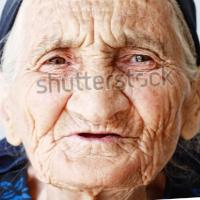

1


In [3]:
display(images[0])
print(genders[0])

In [4]:
images = pd.Series([np.asarray(image.resize((200,200), Image.LANCZOS)).transpose(2,0,1)/255.
                        for image in images], 
                    name = 'Images')
genders = pd.Series(list(genders), name = 'Genders')
images[0].shape

(3, 200, 200)

In [5]:
global_df = pd.concat([images, genders], axis=1)
global_df.sample(3)

,Images,Genders
3249,"[[[0.9372549019607843, 0.8901960784313725, 0.8...",1
741,"[[[0.22745098039215686, 0.2, 0.184313725490196...",0
4735,"[[[0.0392156862745098, 0.07058823529411765, 0....",0


In [6]:
global_df = global_df.loc[global_df['Genders'] <= 1]
global_df.shape

(7999, 2)

In [7]:
data_indices = global_df.index.values
idx_train, idx_test = train_test_split(data_indices, test_size=0.2, random_state=42)
idx_train, idx_valid = train_test_split(idx_train, test_size=0.25, random_state=42)
idx_train.shape, idx_valid.shape, idx_test.shape

((4799,), (1600,), (1600,))

In [8]:
class ImageDataset(Dataset):
    def __init__(self, indices, test=False):
        self.test = test
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if self.test:
            return global_df['Images'][self.indices[idx]]
        else:
            return global_df['Images'][self.indices[idx]], global_df['Genders'][self.indices[idx]]


In [10]:
def collate(batch):
    images = torch.FloatTensor([image for image, target in batch]).to(global_device)
    targets = torch.FloatTensor([target for image, target in batch]).to(global_device)
    return images, targets

def collate_test(batch):
    images = torch.FloatTensor(batch).to(global_device)
    return images

batch_size = 64

dataset_train = ImageDataset(idx_train, test=False)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate)

dataset_val = ImageDataset(idx_valid, test=False)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate)

dataset_test = ImageDataset(idx_test, test=True)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_test)

### CNN model with pytorch lightning

In [22]:
class ClassificationCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=(3,3), padding=(1,1)),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Flatten(start_dim=1, end_dim=-1),
                        nn.Linear(25*25*128, 64),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(64, 1),
                        nn.Sigmoid()
                    )

        self.loss = nn.BCELoss()
        self.metric = accuracy_score
        
    def forward(self, images):
        outs = self.layers(images)
        return outs

    def training_step(self, batch, batch_idx):
        images, target = batch
        preds = self(images)
        preds = preds.squeeze()
        loss = self.loss(preds, target)
        acc = self.metric(target.cpu().numpy(), np.round(preds.cpu().detach().numpy()))
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, target = batch
        preds = self(images)
        preds = preds.squeeze()
        loss = self.loss(preds, target)
        acc = self.metric(target.cpu().numpy(), np.round(preds.cpu().detach().numpy()))
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer}

In [23]:
trainer = pl.Trainer(accelerator="gpu", devices=1,
                     val_check_interval=0.5, max_epochs=20, log_every_n_steps=15)
model = ClassificationCNN()
# trainer.validate(model, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, dataloader_train, dataloader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.2 M 
1 | loss   | BCELoss    | 0     
--------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.854    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 17:   8%|▊         | 6/75 [00:27<05:14,  4.56s/it, v_num=49, train_loss=0.218, train_acc=0.875, val_loss=0.439, val_acc=0.816]  

In [ ]:
''' example load trained model from checkpoint '''
# model = RegressionCNN.load_from_checkpoint('lightning_logs/version_28/checkpoints/epoch=19-step=20.ckpt')

### Training process visualisation

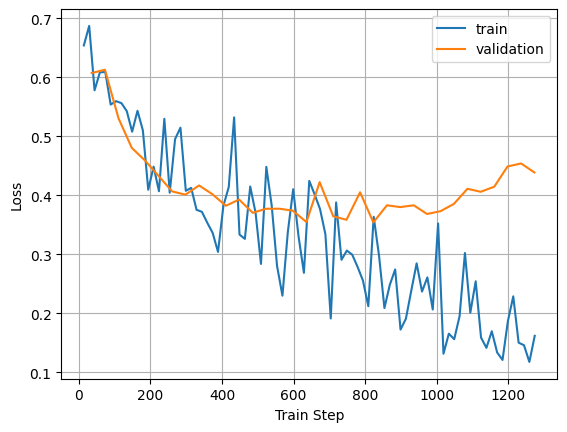

In [25]:
metrics = pd.read_csv('lightning_logs/version_49/metrics.csv')
train_metrics = metrics.dropna(subset=['train_loss'])
val_metrics = metrics.dropna(subset=['val_loss'])
plt.plot(train_metrics['step'], train_metrics['train_loss'], label="train")
plt.plot(val_metrics['step'], val_metrics['val_loss'], label="validation")
plt.xlabel('Train Step')
plt.ylabel('Loss')
plt.legend()
plt.grid()
# plt.yscale('log')

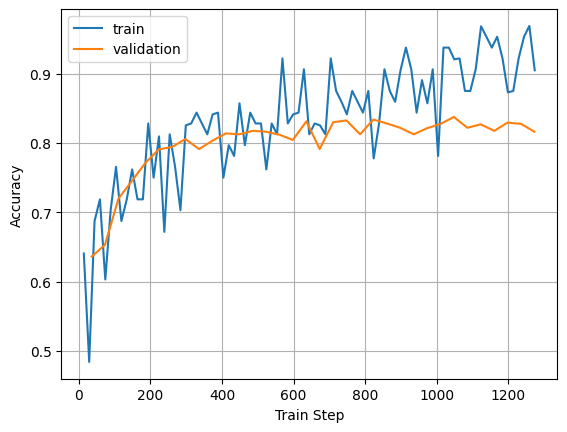

In [26]:
plt.plot(train_metrics['step'], train_metrics['train_acc'], label="train")
plt.plot(val_metrics['step'], val_metrics['val_acc'], label="validation")
plt.xlabel('Train Step')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

### New images prediction

In [31]:
def predict(model, loader):
    model.to(global_device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in loader:
            preds = model(images).cpu()
            predictions.append(np.round(preds.cpu().numpy()))
    predictions = np.vstack(predictions)
    return predictions

In [32]:
test_pred = predict(model, dataloader_test)
accuracy_score(global_df["Genders"][idx_test], test_pred)

0.82625